<a href="https://colab.research.google.com/github/jrstevenjlab/ColaboratoryGlueX/blob/master/plot_dirc_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
print(" > Installing uproot...")
!pip install uproot

 > Installing uproot...


In [4]:
import uproot

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import keras and tensorflow
import keras
import tensorflow

# The digits dataset
#digits = datasets.load_digits()
#print(digits.data)

#Display the first digit
#plt.figure(1, figsize=(3, 3))
#plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
#plt.show()

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
# initialize images
image_kplus = np.zeros(shape=(48,144))
image_piplus = np.zeros(shape=(48,144))
images_kplus = []
images_piplus = []
images_flat_kplus = []
images_flat_piplus = []

#h2_kplus = ROOT.TH2F("kplus","Hit Pattern K+; PixelRow; PixelCol",144,-0.5,143.5,48,-0.5,47.5)
#h2_piplus = ROOT.TH2F("piplus","Hit Pattern pi+; PixelRow; PixelCol",144,-0.5,143.5,48,-0.5,47.5)

# get data from files
print("Opening files")
piplus = uproot.open("/content/gdrive/My Drive/piplus_p3_theta4_flat.root")["dircml_flat"]
kplus = uproot.open("/content/gdrive/My Drive/kplus_p3_theta4_flat.root")["dircml_flat"]

# fill histogram with # photon hits
#plt.axis([0, 250, 0, 5000])
#plt.hist(NPixelsArr, 4000) #, 0, 100) #bins='auto')
#plt.title("Histogram with 'auto' bins")
#plt.show()

eventMax = 10000
eventCounter = 0

print("Filling image arrays")
# loop over kplus events
for (PixelTimes,PixelRows,PixelCols) in zip(kplus.array("PixelTime"),kplus.array("PixelRow"),kplus.array("PixelCol")):
    #print("event")
    image_single = np.zeros(shape=(48,144))
    
    # loop over pixels within event
    for (PixelTime,PixelRow,PixelCol) in zip(PixelTimes,PixelRows,PixelCols):
        #print("PixelTime,Row,Col = %f,%d,%d" % (PixelTime,PixelRow,PixelCol))
        image_kplus[PixelCol,PixelRow] += 1
        image_single[PixelCol,PixelRow] = PixelTime
        #h2_kplus.Fill(PixelRow,PixelCol)
    
    # after each event
    images_kplus.append(image_single)
    images_flat_kplus.append(np.reshape(image_single, 6912))
    
    eventCounter = eventCounter+1
    if eventCounter > eventMax:
        break

eventCounter = 0
        
# loop over piplus events
for (PixelTimes,PixelRows,PixelCols) in zip(piplus.array("PixelTime"),piplus.array("PixelRow"),piplus.array("PixelCol")):
    #print("event")
    image_single = np.zeros(shape=(48,144))
    
    # loop over pixels within event
    for (PixelTime,PixelRow,PixelCol) in zip(PixelTimes,PixelRows,PixelCols):
        #print("PixelTime,Row,Col = %f,%d,%d" % (PixelTime,PixelRow,PixelCol))
        image_piplus[PixelCol,PixelRow] += 1
        image_single[PixelCol,PixelRow] = PixelTime
        #h2_piplus.Fill(PixelRow,PixelCol)
    
    # after each event
    images_piplus.append(image_single)
    images_flat_piplus.append(np.reshape(image_single, 6912))
    
    eventCounter = eventCounter+1
    if eventCounter > eventMax:
        break

Opening files
Filling image arrays


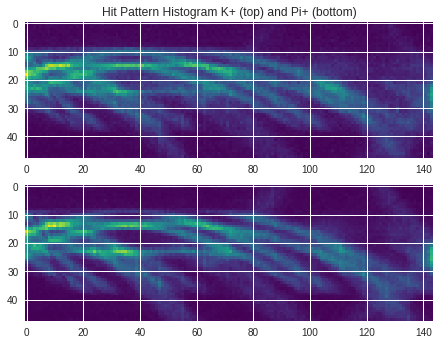

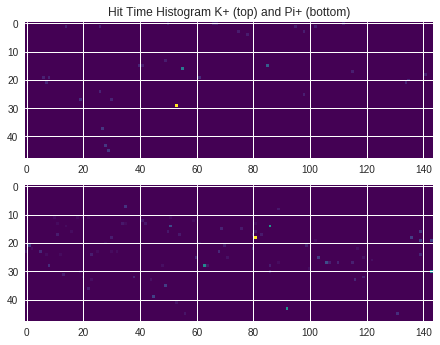

In [15]:
# draw cumulative image
plt.axis([-0.5, 143.5, -0.5, 47.5])
plt.subplot(2, 1, 1)
plt.title("Hit Pattern Histogram K+ (top) and Pi+ (bottom)")
plt.imshow(image_kplus, cmap='viridis')
plt.subplot(2, 1, 2)
plt.title("")
plt.imshow(image_piplus, cmap='viridis')
plt.show()

# draw single event image
plt.subplot(2, 1, 1)
plt.title("Hit Time Histogram K+ (top) and Pi+ (bottom)")
plt.imshow(images_kplus[0], cmap='viridis')
plt.subplot(2, 1, 2)
plt.title("")
plt.imshow(images_piplus[0], cmap='viridis')
#plt.show()

# draw ROOT image
#can = ROOT.TCanvas("cc","cc",600,500)
#can.Divide(1,2)
#can.cd(1)
#h2_kplus.Draw("colz")
#can.cd(2)
#h2_piplus.Draw("colz")
#can.Print("HitPattern.png")

In [16]:
# Split samples into training and testing
print("Splitting sample into training and testing subsets")
n_kplus = len(images_kplus)
n_piplus = len(images_piplus)
n_total = n_kplus + n_piplus

images_train_kplus = images_flat_kplus[:n_kplus // 2]
images_train_piplus = images_flat_piplus[:n_piplus // 2]
n_train_kplus = len(images_train_kplus)
n_train_piplus = len(images_train_piplus)
n_train_total = n_train_kplus + n_train_piplus

images_test_kplus = images_flat_kplus[n_kplus // 2:]
images_test_piplus = images_flat_piplus[n_piplus // 2:]
n_test_kplus = len(images_test_kplus)
n_test_piplus = len(images_test_piplus)
n_test_total = n_test_kplus + n_test_piplus

data_train = np.concatenate((images_train_kplus, images_train_piplus))
data_test = np.concatenate((images_test_kplus, images_test_piplus))
data = np.concatenate((images_kplus, images_piplus))

target_train = np.concatenate((np.ones(n_train_kplus), np.zeros(n_train_piplus)))
target_test = np.concatenate((np.ones(n_test_kplus), np.zeros(n_test_piplus)))
target = np.concatenate((np.ones(n_kplus), np.zeros(n_piplus)))

print(data.shape)
print(target.shape)
print(np.unique(target))
print("Training size = %d" % len(data_train))
print("Testing size = %d" % len(data_test))

Splitting sample into training and testing subsets
(20002, 48, 144)
(20002,)
[0. 1.]
Training size = 10000
Testing size = 10002


In [19]:
###################  Scikit-learn  #################

# Create a classifier
print("Creating classifier")
#classifier = SVC()
#classifier = AdaBoostClassifier()
classifier = MLPClassifier()

# Fit the classifier on training sample
print("Fitting classifier")
classifier.fit(data_train, target_train)

# Evaluate the classifier with the test sample
print("Evaluating classifier performance")
expected = target_test
predicted = classifier.predict(data_test)
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

'''
###################  TensorFlow  #################

# setup Keras NN layers(?)
classifier = keras.Sequential([keras.layers.Dense(128, activation=tensorflow.nn.relu), keras.layers.Dense(2, activation=tensorflow.nn.softmax)]) # keras.layers.Flatten(input_shape=(48, 144)) -> if need to flatten 2D image, but I've already done this

# Compile TensorFlow classifier
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the classifier on training sample
classifier.fit(data_train, target_train, epochs=5)

# Evaluate the classifier with the test sample
test_loss, test_acc = classifier.evaluate(data_test, target_test)
print("Test accuracy:", test_acc)

predictions = classifier.predict(data_test)
'''

Creating classifier
Fitting classifier
Evaluating classifier performance
Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82      5001
         1.0       0.84      0.78      0.81      5001

   micro avg       0.82      0.82      0.82     10002
   macro avg       0.82      0.82      0.82     10002
weighted avg       0.82      0.82      0.82     10002


Confusion matrix:
[[4263  738]
 [1092 3909]]


'\n###################  TensorFlow  #################\n\n# setup Keras NN layers(?)\nclassifier = keras.Sequential([keras.layers.Dense(128, activation=tensorflow.nn.relu), keras.layers.Dense(2, activation=tensorflow.nn.softmax)]) # keras.layers.Flatten(input_shape=(48, 144)) -> if need to flatten 2D image, but I\'ve already done this\n\n# Compile TensorFlow classifier\nclassifier.compile(optimizer=\'adam\', loss=\'sparse_categorical_crossentropy\', metrics=[\'accuracy\'])\n\n# Fit the classifier on training sample\nclassifier.fit(data_train, target_train, epochs=5)\n\n# Evaluate the classifier with the test sample\ntest_loss, test_acc = classifier.evaluate(data_test, target_test)\nprint("Test accuracy:", test_acc)\n\npredictions = classifier.predict(data_test)\n'

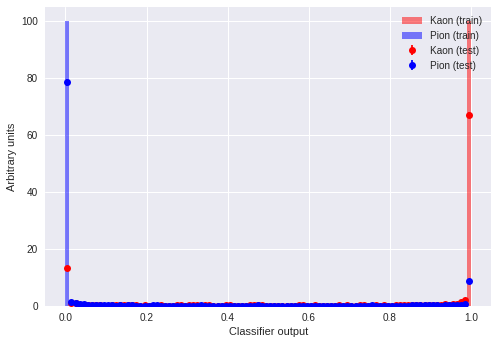

In [18]:
###################  Evaluation  #################

# Evaluate performance by comparing test and training classifier response
decisions = []
for (X,y) in ((data_train, target_train), (data_test, target_test)):
    d1 = 0
    d2 = 0
    if hasattr(classifier, "decision_function"):
        d1 = classifier.decision_function(X[y>0.5]).ravel()
        d2 = classifier.decision_function(X[y<0.5]).ravel()
    elif hasattr(classifier, "predict_proba"):
        d1 = classifier.predict_proba(X[y>0.5])[:,1].ravel()
        d2 = classifier.predict_proba(X[y<0.5])[:,1].ravel()
    elif hasattr(classifier, "predict"):
        d1 = classifier.predict(X[y>0.5])[:,1].ravel()
        d2 = classifier.predict(X[y<0.5])[:,1].ravel()
    decisions += [d1, d2]
#print(X)
#print(y)
#print(decisions)

bins = 100
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low,high)

plt.clf()
plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='Kaon (train)')
plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=True, label='Pion (train)')

# make histogram and get error bars
hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, density=True)
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

# plot histogram for signal test sample
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Kaon (test)')

# make and plot histogram for background test sample
hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Pion (test)')

plt.xlabel("Classifier output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.show()